# Extract DINEOF and DINCAE Metrics from Pipeline Outputs

This notebook extracts the following metrics:
- **dineof_cvrms**: Expected error calculated by cross-validation (from DINEOF logs)
- **dincae_cvrms**: CV_RMS from DINCAE cv_rms.txt files
- **variance_initial**: Total variance of the initial matrix (from DINEOF logs)
- **variance_reconstructed**: Total variance of the reconstructed matrix (from DINEOF logs)

## Setup

In [1]:
import json
import os
import re
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import pandas as pd

## Configuration

Set your directories here:

In [2]:
# ============================================
# CONFIGURE THESE PATHS
# ============================================

folder_name = "archive/anomaly-20251126-c84211-exp1"

# Directory containing logs/ folder (DINEOF outputs)
DINEOF_DIR = f"/gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/{folder_name}/"

# Directory containing dincae/ folder (DINCAE outputs)
# Set to same as DINEOF_DIR if they're in the same run root
DINCAE_DIR = f"/gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/{folder_name}/"

# Output directory (None = same as DINEOF_DIR)
OUTPUT_DIR = None

# Alpha slug for DINCAE subdirectories
ALPHA_SLUG = "a1000"

# Lake locations CSV file (should be in the same folder as this notebook)
LAKE_LOCATIONS_CSV = "filtered_lakes_lake_summary_results_from2000_QL45.csv"

# ============================================

dineof_base = Path(DINEOF_DIR)
dincae_base = Path(DINCAE_DIR)
logs_dir = dineof_base / "logs"
out_path = Path(OUTPUT_DIR) if OUTPUT_DIR else dineof_base

print(f"DINEOF dir (logs): {dineof_base}")
print(f"DINCAE dir: {dincae_base}")
print(f"Output dir: {out_path}")
print(f"Alpha slug: {ALPHA_SLUG}")
print(f"Lake locations CSV: {LAKE_LOCATIONS_CSV}")
print()
print(f"Logs dir exists: {logs_dir.exists()}")
print(f"DINCAE dir exists: {(dincae_base / 'dincae').exists()}")
print(f"Lake locations CSV exists: {Path(LAKE_LOCATIONS_CSV).exists()}")

DINEOF dir (logs): /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/archive/anomaly-20251126-c84211-exp1
DINCAE dir: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/archive/anomaly-20251126-c84211-exp1
Output dir: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/archive/anomaly-20251126-c84211-exp1
Alpha slug: a1000
Lake locations CSV: filtered_lakes_lake_summary_results_from2000_QL45.csv

Logs dir exists: True
DINCAE dir exists: True
Lake locations CSV exists: True


## Helper Functions

In [3]:
def extract_lake_id_from_filename(filename: str) -> Optional[int]:
    """
    Extract lake ID from log filename.
    
    Expected patterns:
      - chain_lake3007_row0_12345.out
      - dineof_lake3007_row0_12345.out
    """
    match = re.search(r'lake(\d+)', filename, re.IGNORECASE)
    if match:
        return int(match.group(1))
    return None


def extract_dineof_metrics_from_content(content: str) -> Dict[str, Optional[float]]:
    """
    Extract DINEOF metrics from log file content.
    """
    metrics = {
        'dineof_cvrms': None,
        'variance_initial': None,
        'variance_reconstructed': None,
    }
    
    # Pattern for: expected error calculated by cross-validation          0.7828
    cvrms_pattern = r'expected\s+error\s+calculated\s+by\s+cross-validation\s+([\d.]+(?:[eE][+-]?\d+)?)'
    match = re.search(cvrms_pattern, content, re.IGNORECASE)
    if match:
        try:
            metrics['dineof_cvrms'] = float(match.group(1))
        except ValueError:
            pass
    
    # Pattern for: total variance of the initial matrix    4.9608612560127048
    var_init_pattern = r'total\s+variance\s+of\s+the\s+initial\s+matrix\s+([\d.]+(?:[eE][+-]?\d+)?)'
    match = re.search(var_init_pattern, content, re.IGNORECASE)
    if match:
        try:
            metrics['variance_initial'] = float(match.group(1))
        except ValueError:
            pass
    
    # Pattern for: total variance of the reconstructed matrix    5.4089640144865028
    var_recon_pattern = r'total\s+variance\s+of\s+the\s+reconstructed\s+matrix\s+([\d.]+(?:[eE][+-]?\d+)?)'
    match = re.search(var_recon_pattern, content, re.IGNORECASE)
    if match:
        try:
            metrics['variance_reconstructed'] = float(match.group(1))
        except ValueError:
            pass
    
    return metrics


def extract_dincae_cvrms(cv_rms_path: Path) -> Optional[float]:
    """
    Extract CV_RMS from a DINCAE cv_rms.txt file.
    
    Expected content format:
        CV_RMS 1.098578
    """
    if not cv_rms_path.exists():
        return None
    
    try:
        content = cv_rms_path.read_text().strip()
        match = re.search(r'CV_RMS\s+([\d.]+(?:[eE][+-]?\d+)?)', content, re.IGNORECASE)
        if match:
            return float(match.group(1))
    except Exception:
        pass
    
    return None


def find_dincae_cv_files(dincae_base: Path, alpha_slug: str = "a1000") -> Dict[int, Path]:
    """
    Find all DINCAE cv_rms.txt files and map them to lake IDs.
    
    Expected structure: {dincae_base}/dincae/{lake_id9}/{alpha_slug}/cv_rms.txt
    """
    dincae_dir = dincae_base / "dincae"
    if not dincae_dir.exists():
        return {}
    
    lake_cv_files = {}
    
    for lake_dir in dincae_dir.iterdir():
        if not lake_dir.is_dir():
            continue
        
        try:
            lake_id = int(lake_dir.name)
        except ValueError:
            continue
        
        cv_rms_path = lake_dir / alpha_slug / "cv_rms.txt"
        if cv_rms_path.exists():
            lake_cv_files[lake_id] = cv_rms_path
    
    return lake_cv_files

## Process DINEOF Log Files

In [4]:
# Find all .out log files
log_files = sorted(logs_dir.glob("*.out")) if logs_dir.exists() else []
print(f"Found {len(log_files)} .out files in {logs_dir}")

if log_files:
    print("\nFirst 5 files:")
    for f in log_files[:5]:
        print(f"  {f.name}")

Found 121 .out files in /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/archive/anomaly-20251126-c84211-exp1/logs

First 5 files:
  chain_lake1046_row69_52060183.out
  chain_lake1115_row70_52060183.out
  chain_lake1146_row71_52060183.out
  chain_lake1196_row72_52060183.out
  chain_lake11_row5_52060183.out


In [5]:
# Process all DINEOF log files
lake_data: Dict[int, Dict] = {}
skipped_lakes_dineof: List[int] = []
files_without_lake_id: List[str] = []

for log_path in log_files:
    filename = log_path.name
    lake_id = extract_lake_id_from_filename(filename)
    
    if lake_id is None:
        files_without_lake_id.append(filename)
        continue
    
    try:
        content = log_path.read_text(errors='replace')
    except Exception as e:
        print(f"Warning: Could not read {log_path}: {e}")
        if lake_id not in lake_data:
            skipped_lakes_dineof.append(lake_id)
        continue
    
    metrics = extract_dineof_metrics_from_content(content)
    has_data = any(v is not None for v in metrics.values())
    
    if has_data:
        if lake_id in lake_data:
            # Merge: prefer non-None values
            existing = lake_data[lake_id]
            for key, value in metrics.items():
                if value is not None and existing.get(key) is None:
                    existing[key] = value
        else:
            lake_data[lake_id] = {'lake_id': lake_id, **metrics}
    else:
        if lake_id not in lake_data:
            skipped_lakes_dineof.append(lake_id)

print(f"\nExtracted DINEOF metrics for {len(lake_data)} lakes")
print(f"Lakes without DINEOF data: {len(set(skipped_lakes_dineof))}")
if files_without_lake_id:
    print(f"Files ignored (no lake_id): {len(files_without_lake_id)}")


Extracted DINEOF metrics for 103 lakes
Lakes without DINEOF data: 17


## Process DINCAE cv_rms.txt Files

In [6]:
# Find DINCAE cv_rms.txt files
dincae_cv_files = find_dincae_cv_files(dincae_base, ALPHA_SLUG)
print(f"Found {len(dincae_cv_files)} cv_rms.txt files in {dincae_base / 'dincae'}")

if dincae_cv_files:
    print("\nFirst 5:")
    for lake_id, path in list(dincae_cv_files.items())[:5]:
        print(f"  Lake {lake_id}: {path}")

Found 103 cv_rms.txt files in /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/archive/anomaly-20251126-c84211-exp1/dincae

First 5:
  Lake 321: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/archive/anomaly-20251126-c84211-exp1/dincae/000000321/a1000/cv_rms.txt
  Lake 513: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/archive/anomaly-20251126-c84211-exp1/dincae/000000513/a1000/cv_rms.txt
  Lake 586: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/archive/anomaly-20251126-c84211-exp1/dincae/000000586/a1000/cv_rms.txt
  Lake 174: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/archive/anomaly-20251126-c84211-exp1/dincae/000000174/a1000/cv_rms.txt
  Lake 463: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/archive/anomaly-20251126-c84211-exp1/dincae/000000463/a1000/cv_rms.txt


In [7]:
# Process DINCAE cv_rms.txt files
skipped_lakes_dincae: List[int] = []
dincae_only_lakes: List[int] = []

for lake_id, cv_path in dincae_cv_files.items():
    cvrms = extract_dincae_cvrms(cv_path)
    
    if cvrms is not None:
        if lake_id in lake_data:
            lake_data[lake_id]['dincae_cvrms'] = cvrms
        else:
            # Lake has DINCAE data but no DINEOF data
            lake_data[lake_id] = {
                'lake_id': lake_id,
                'dineof_cvrms': None,
                'dincae_cvrms': cvrms,
                'variance_initial': None,
                'variance_reconstructed': None,
            }
            dincae_only_lakes.append(lake_id)
    else:
        skipped_lakes_dincae.append(lake_id)

# Ensure all records have dincae_cvrms key
for lake_id, data in lake_data.items():
    if 'dincae_cvrms' not in data:
        data['dincae_cvrms'] = None

print(f"\nExtracted DINCAE metrics: {sum(1 for d in lake_data.values() if d.get('dincae_cvrms') is not None)}")
print(f"Lakes with DINCAE only (no DINEOF): {len(dincae_only_lakes)}")
print(f"DINCAE files skipped (parse error): {len(skipped_lakes_dincae)}")


Extracted DINCAE metrics: 103
Lakes with DINCAE only (no DINEOF): 0
DINCAE files skipped (parse error): 0


## Create DataFrame

In [8]:
# Compile skipped lakes
skipped_lakes = sorted(set(skipped_lakes_dineof) - set(lake_data.keys()))

# Convert to DataFrame with proper column order
data_list = sorted(lake_data.values(), key=lambda x: x['lake_id'])

if data_list:
    df = pd.DataFrame(data_list)
    df = df[['lake_id', 'dineof_cvrms', 'dincae_cvrms', 'variance_initial', 'variance_reconstructed']]
    print(f"DataFrame shape: {df.shape}")
    display(df.head(20))
else:
    df = pd.DataFrame(columns=['lake_id', 'dineof_cvrms', 'dincae_cvrms', 'variance_initial', 'variance_reconstructed'])
    print("No data extracted!")

DataFrame shape: (103, 5)


,lake_id,dineof_cvrms,dincae_cvrms,variance_initial,variance_reconstructed
0,9,0.7086,0.852156,1.709100,1.675385
1,11,0.9490,1.049029,2.675521,2.601371
2,12,0.5810,0.700704,1.569513,1.383127
3,13,0.6301,0.848047,2.515589,2.585795
4,15,0.5939,0.797156,1.696626,1.680317
5,20,0.2712,0.251141,0.263040,0.214351
6,21,0.4753,0.483801,0.492262,0.347336
7,25,0.5744,0.526290,0.985192,0.773618
8,26,1.0796,1.189756,2.781873,2.273318
9,35,0.2987,0.364299,0.345228,0.507881


## Summary Statistics

In [9]:
if len(df) > 0:
    n_with_dineof = df['dineof_cvrms'].notna().sum()
    n_with_dincae = df['dincae_cvrms'].notna().sum()
    n_with_both = ((df['dineof_cvrms'].notna()) & (df['dincae_cvrms'].notna())).sum()
    
    print("="*60)
    print("EXTRACTION SUMMARY")
    print("="*60)
    print(f"Total lakes with data: {len(df)}")
    print(f"  - With DINEOF CV-RMS: {n_with_dineof}")
    print(f"  - With DINCAE CV-RMS: {n_with_dincae}")
    print(f"  - With both: {n_with_both}")
    print(f"Skipped (no data): {len(skipped_lakes)}")
    print()
    print("Summary Statistics:")
    display(df.describe())
    
    print("\nMissing values:")
    print(df.isnull().sum())

EXTRACTION SUMMARY
Total lakes with data: 103
  - With DINEOF CV-RMS: 103
  - With DINCAE CV-RMS: 103
  - With both: 103
Skipped (no data): 17

Summary Statistics:


,lake_id,dineof_cvrms,dincae_cvrms,variance_initial,variance_reconstructed
count,1.030000e+02,103.000000,103.000000,103.000000,103.000000
mean,4.951667e+07,0.588347,0.869985,2.057252,2.194869
std,1.119143e+08,0.282666,0.345734,1.429426,1.593015
min,9.000000e+00,0.254400,0.251141,0.263040,0.214351
25%,2.250000e+02,0.405800,0.568167,0.868904,0.889557
50%,5.710000e+02,0.535800,0.828069,1.761588,1.975335
75%,1.953000e+03,0.694600,1.069605,2.681144,2.964181
max,3.000154e+08,2.191900,1.849541,5.964749,9.536360



Missing values:
lake_id                   0
dineof_cvrms              0
dincae_cvrms              0
variance_initial          0
variance_reconstructed    0
dtype: int64


## Save Outputs

In [10]:
# Ensure output directory exists
out_path.mkdir(parents=True, exist_ok=True)

# Save CSV
csv_path = out_path / "dineof_metrics.csv"
df.to_csv(csv_path, index=False)
print(f"Saved CSV: {csv_path}")

# Save JSON
json_path = out_path / "dineof_metrics.json"
n_with_dineof = int(df['dineof_cvrms'].notna().sum())
n_with_dincae = int(df['dincae_cvrms'].notna().sum())
n_with_both = int(((df['dineof_cvrms'].notna()) & (df['dincae_cvrms'].notna())).sum())

with open(json_path, 'w') as f:
    json.dump({
        'dineof_dir': str(dineof_base),
        'dincae_dir': str(dincae_base),
        'alpha_slug': ALPHA_SLUG,
        'n_lakes': len(data_list),
        'n_with_dineof_cvrms': n_with_dineof,
        'n_with_dincae_cvrms': n_with_dincae,
        'n_with_both': n_with_both,
        'n_skipped': len(skipped_lakes),
        'data': data_list
    }, f, indent=2)
print(f"Saved JSON: {json_path}")

# Save skipped lakes
skipped_path = out_path / "dineof_metrics_skipped.txt"
with open(skipped_path, 'w') as f:
    f.write(f"# Lakes skipped (no metrics found)\n")
    f.write(f"# DINEOF dir: {dineof_base}\n")
    f.write(f"# DINCAE dir: {dincae_base}\n")
    f.write(f"# Total skipped: {len(skipped_lakes)}\n\n")
    for lake_id in skipped_lakes:
        f.write(f"{lake_id}\n")
print(f"Saved skipped list: {skipped_path}")

Saved CSV: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/archive/anomaly-20251126-c84211-exp1/dineof_metrics.csv
Saved JSON: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/archive/anomaly-20251126-c84211-exp1/dineof_metrics.json
Saved skipped list: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/archive/anomaly-20251126-c84211-exp1/dineof_metrics_skipped.txt


## Visualization: DINEOF vs DINCAE Comparison

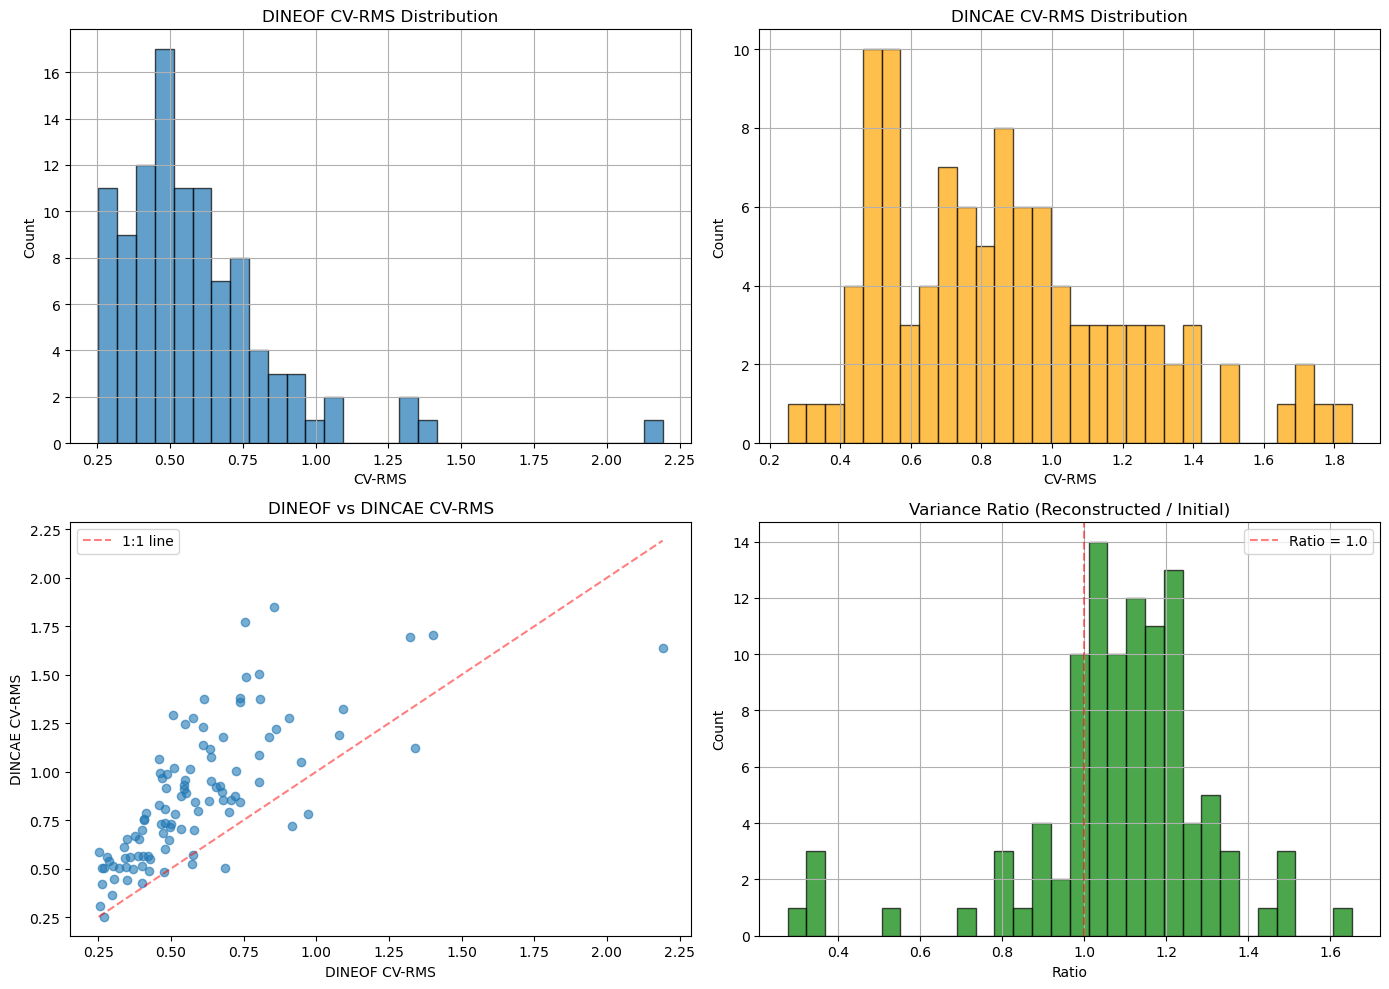

Saved plots: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/archive/anomaly-20251126-c84211-exp1/dineof_metrics_plots.png


In [11]:
try:
    import matplotlib.pyplot as plt
    
    if len(df) > 0 and df['dineof_cvrms'].notna().any() and df['dincae_cvrms'].notna().any():
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. DINEOF CV-RMS distribution
        ax1 = axes[0, 0]
        df['dineof_cvrms'].dropna().hist(ax=ax1, bins=30, edgecolor='black', alpha=0.7)
        ax1.set_title('DINEOF CV-RMS Distribution')
        ax1.set_xlabel('CV-RMS')
        ax1.set_ylabel('Count')
        
        # 2. DINCAE CV-RMS distribution
        ax2 = axes[0, 1]
        df['dincae_cvrms'].dropna().hist(ax=ax2, bins=30, edgecolor='black', alpha=0.7, color='orange')
        ax2.set_title('DINCAE CV-RMS Distribution')
        ax2.set_xlabel('CV-RMS')
        ax2.set_ylabel('Count')
        
        # 3. DINEOF vs DINCAE scatter plot
        ax3 = axes[1, 0]
        both_mask = df['dineof_cvrms'].notna() & df['dincae_cvrms'].notna()
        if both_mask.any():
            df_both = df[both_mask]
            ax3.scatter(df_both['dineof_cvrms'], df_both['dincae_cvrms'], alpha=0.6)
            
            # Add 1:1 line
            lims = [
                min(df_both['dineof_cvrms'].min(), df_both['dincae_cvrms'].min()),
                max(df_both['dineof_cvrms'].max(), df_both['dincae_cvrms'].max())
            ]
            ax3.plot(lims, lims, 'r--', alpha=0.5, label='1:1 line')
            ax3.set_xlabel('DINEOF CV-RMS')
            ax3.set_ylabel('DINCAE CV-RMS')
            ax3.set_title('DINEOF vs DINCAE CV-RMS')
            ax3.legend()
        else:
            ax3.text(0.5, 0.5, 'No lakes with both\nDINEOF and DINCAE data', 
                     ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('DINEOF vs DINCAE CV-RMS')
        
        # 4. Variance ratio
        ax4 = axes[1, 1]
        if df['variance_initial'].notna().any() and df['variance_reconstructed'].notna().any():
            var_ratio = df['variance_reconstructed'] / df['variance_initial']
            var_ratio.dropna().hist(ax=ax4, bins=30, edgecolor='black', alpha=0.7, color='green')
            ax4.axvline(1.0, color='red', linestyle='--', alpha=0.5, label='Ratio = 1.0')
            ax4.set_title('Variance Ratio (Reconstructed / Initial)')
            ax4.set_xlabel('Ratio')
            ax4.set_ylabel('Count')
            ax4.legend()
        else:
            ax4.text(0.5, 0.5, 'No variance data', ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Variance Ratio')
        
        plt.tight_layout()
        fig_path = out_path / "dineof_metrics_plots.png"
        plt.savefig(fig_path, dpi=150)
        plt.show()
        print(f"Saved plots: {fig_path}")
    else:
        print("Not enough data for visualization")
        
except ImportError:
    print("matplotlib not available - skipping visualization")

## Global Map: CV-RMS by Lake Location

This section creates global scatter plots showing CV-RMS values at each lake's geographic location.
Dot size represents the error magnitude (larger dots = higher CV-RMS).

In [12]:
# Load lake locations from CSV
try:
    df_locations = pd.read_csv(LAKE_LOCATIONS_CSV)
    print(f"Loaded lake locations: {len(df_locations)} lakes")
    print(f"Columns: {list(df_locations.columns)}")
    
    # Standardize column names (handle potential variations)
    # Rename columns to lowercase for easier access
    col_mapping = {}
    for col in df_locations.columns:
        if 'lake_id' in col.lower() or col.lower() == 'lake_id':
            col_mapping[col] = 'lake_id'
        elif 'lat' in col.lower() and 'centre' in col.lower():
            col_mapping[col] = 'lat'
        elif 'lon' in col.lower() and 'centre' in col.lower():
            col_mapping[col] = 'lon'
    
    df_locations = df_locations.rename(columns=col_mapping)
    print(f"\nRenamed columns: lake_id, lat, lon")
    print(f"Sample locations:")
    display(df_locations[['lake_id', 'lat', 'lon']].head())
    
except FileNotFoundError:
    print(f"ERROR: Lake locations CSV not found: {LAKE_LOCATIONS_CSV}")
    print("Please ensure the CSV file is in the same directory as this notebook.")
    df_locations = None
except Exception as e:
    print(f"ERROR loading lake locations: {e}")
    df_locations = None

Loaded lake locations: 120 lakes
Columns: ['lake_id', 'NAME', 'COUNTRY', 'MAX DISTANCE TO LAND (KM)', 'LAT CENTRE', 'LON CENTRE', 'N PIXELS LSWT_mean', 'N PIXELS LSWT_std', 'N PIXELS CLIM_mean', 'N PIXELS CLIM_std', 'LSWT_spatial_mean', 'LSWT_spatial_std', 'PIXELS_PERCENTAGE_mean', 'PIXELS_PERCENTAGE_std', 'max_N_no_obs_consecutive_days', 'N_no_obs_consecutive_days_mean', 'N_no_obs_consecutive_days_std', 'longest_duration_days', 'Freq_Rank', 'N_obs_days_mean', 'N_obs_days_std', 'selection', 'Insitu-only flag', 'LIC-only flag', 'LSWT-only flag', 'UOR_selection_flag', 'UOR_LIC_with_insitu_flag', 'lake_cluster_flag', 'Form ice flag']

Renamed columns: lake_id, lat, lon
Sample locations:


,lake_id,lat,lon
0,2,47.9625,-87.0431
1,5,44.7208,-82.3458
2,6,42.6042,-87.0153
3,8,54.1736,108.9736
4,9,66.0125,-120.3764


In [13]:
# Merge metrics with locations
if df_locations is not None and len(df) > 0:
    # Merge on lake_id
    df_merged = df.merge(df_locations[['lake_id', 'lat', 'lon']], on='lake_id', how='left')
    
    n_with_location = df_merged['lat'].notna().sum()
    n_missing_location = df_merged['lat'].isna().sum()
    
    print(f"Merged metrics with locations:")
    print(f"  - Lakes with location: {n_with_location}")
    print(f"  - Lakes missing location: {n_missing_location}")
    
    if n_missing_location > 0:
        missing_ids = df_merged[df_merged['lat'].isna()]['lake_id'].tolist()
        print(f"  - Missing lake IDs: {missing_ids[:10]}{'...' if len(missing_ids) > 10 else ''}")
    
    display(df_merged.head())
else:
    df_merged = None
    print("Cannot merge - missing locations data or metrics data")

Merged metrics with locations:
  - Lakes with location: 101
  - Lakes missing location: 2
  - Missing lake IDs: [35, 300000138]


,lake_id,dineof_cvrms,dincae_cvrms,variance_initial,variance_reconstructed,lat,lon
0,9,0.7086,0.852156,1.709100,1.675385,66.0125,-120.3764
1,11,0.9490,1.049029,2.675521,2.601371,61.3347,-114.7958
2,12,0.5810,0.700704,1.569513,1.383127,42.2514,-81.1292
3,13,0.6301,0.848047,2.515589,2.585795,53.4153,-98.4236
4,15,0.5939,0.797156,1.696626,1.680317,43.6653,-77.7625


Using Cartopy for map projection


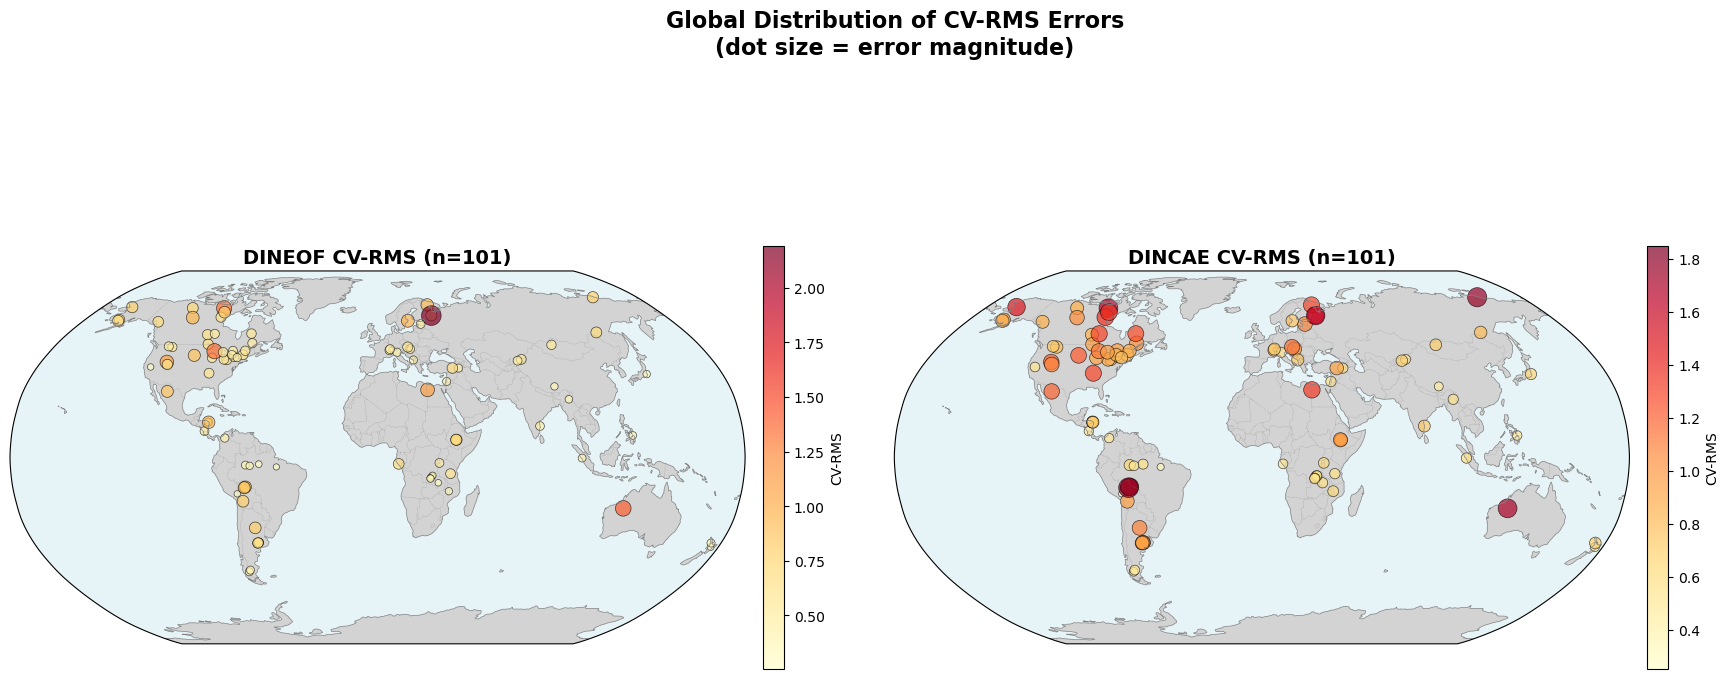


Saved global map: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/archive/anomaly-20251126-c84211-exp1/dineof_metrics_global_map.png


In [14]:
# Create global scatter plots
try:
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Try to import cartopy for proper map projection
    try:
        import cartopy.crs as ccrs
        import cartopy.feature as cfeature
        HAS_CARTOPY = True
        print("Using Cartopy for map projection")
    except ImportError:
        HAS_CARTOPY = False
        print("Cartopy not available - using simple scatter plot")
    
    if df_merged is not None and df_merged['lat'].notna().any():
        # Filter to lakes with valid locations
        df_plot = df_merged[df_merged['lat'].notna()].copy()
        
        # Scaling function for dot sizes
        # Scale CV-RMS to reasonable dot sizes (min 20, max 200)
        def scale_sizes(values, min_size=20, max_size=200):
            valid = values.dropna()
            if len(valid) == 0:
                return values
            vmin, vmax = valid.min(), valid.max()
            if vmax == vmin:
                return np.full_like(values, (min_size + max_size) / 2)
            scaled = (values - vmin) / (vmax - vmin)
            return min_size + scaled * (max_size - min_size)
        
        # Common colormap settings
        cmap = 'YlOrRd'  # Yellow-Orange-Red colormap (low=yellow, high=red)
        
        if HAS_CARTOPY:
            # ========== CARTOPY VERSION ==========
            fig, axes = plt.subplots(1, 2, figsize=(18, 8),
                                     subplot_kw={'projection': ccrs.Robinson()})
            
            # --- DINEOF Plot ---
            ax1 = axes[0]
            ax1.set_global()
            ax1.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='none')
            ax1.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)
            ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='gray')
            ax1.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor='gray', linestyle=':')
            
            df_dineof = df_plot[df_plot['dineof_cvrms'].notna()]
            if len(df_dineof) > 0:
                sizes = scale_sizes(df_dineof['dineof_cvrms'])
                sc1 = ax1.scatter(df_dineof['lon'], df_dineof['lat'],
                                  c=df_dineof['dineof_cvrms'], s=sizes,
                                  cmap=cmap, alpha=0.7, edgecolors='black', linewidth=0.5,
                                  transform=ccrs.PlateCarree())
                cbar1 = plt.colorbar(sc1, ax=ax1, shrink=0.6, pad=0.02)
                cbar1.set_label('CV-RMS', fontsize=10)
            ax1.set_title(f'DINEOF CV-RMS (n={len(df_dineof)})', fontsize=14, fontweight='bold')
            
            # --- DINCAE Plot ---
            ax2 = axes[1]
            ax2.set_global()
            ax2.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='none')
            ax2.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)
            ax2.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='gray')
            ax2.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor='gray', linestyle=':')
            
            df_dincae = df_plot[df_plot['dincae_cvrms'].notna()]
            if len(df_dincae) > 0:
                sizes = scale_sizes(df_dincae['dincae_cvrms'])
                sc2 = ax2.scatter(df_dincae['lon'], df_dincae['lat'],
                                  c=df_dincae['dincae_cvrms'], s=sizes,
                                  cmap=cmap, alpha=0.7, edgecolors='black', linewidth=0.5,
                                  transform=ccrs.PlateCarree())
                cbar2 = plt.colorbar(sc2, ax=ax2, shrink=0.6, pad=0.02)
                cbar2.set_label('CV-RMS', fontsize=10)
            ax2.set_title(f'DINCAE CV-RMS (n={len(df_dincae)})', fontsize=14, fontweight='bold')
            
        else:
            # ========== SIMPLE VERSION (no Cartopy) ==========
            fig, axes = plt.subplots(1, 2, figsize=(18, 8))
            
            # --- DINEOF Plot ---
            ax1 = axes[0]
            df_dineof = df_plot[df_plot['dineof_cvrms'].notna()]
            if len(df_dineof) > 0:
                sizes = scale_sizes(df_dineof['dineof_cvrms'])
                sc1 = ax1.scatter(df_dineof['lon'], df_dineof['lat'],
                                  c=df_dineof['dineof_cvrms'], s=sizes,
                                  cmap=cmap, alpha=0.7, edgecolors='black', linewidth=0.5)
                cbar1 = plt.colorbar(sc1, ax=ax1, shrink=0.8)
                cbar1.set_label('CV-RMS', fontsize=10)
            ax1.set_xlabel('Longitude')
            ax1.set_ylabel('Latitude')
            ax1.set_xlim(-180, 180)
            ax1.set_ylim(-90, 90)
            ax1.set_title(f'DINEOF CV-RMS (n={len(df_dineof)})', fontsize=14, fontweight='bold')
            ax1.grid(True, alpha=0.3)
            
            # --- DINCAE Plot ---
            ax2 = axes[1]
            df_dincae = df_plot[df_plot['dincae_cvrms'].notna()]
            if len(df_dincae) > 0:
                sizes = scale_sizes(df_dincae['dincae_cvrms'])
                sc2 = ax2.scatter(df_dincae['lon'], df_dincae['lat'],
                                  c=df_dincae['dincae_cvrms'], s=sizes,
                                  cmap=cmap, alpha=0.7, edgecolors='black', linewidth=0.5)
                cbar2 = plt.colorbar(sc2, ax=ax2, shrink=0.8)
                cbar2.set_label('CV-RMS', fontsize=10)
            ax2.set_xlabel('Longitude')
            ax2.set_ylabel('Latitude')
            ax2.set_xlim(-180, 180)
            ax2.set_ylim(-90, 90)
            ax2.set_title(f'DINCAE CV-RMS (n={len(df_dincae)})', fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3)
        
        plt.suptitle('Global Distribution of CV-RMS Errors\n(dot size = error magnitude)', 
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        # Save figure
        fig_path = out_path / "dineof_metrics_global_map.png"
        plt.savefig(fig_path, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\nSaved global map: {fig_path}")
    else:
        print("No data with valid locations for global map")
        
except ImportError as e:
    print(f"matplotlib not available - skipping global map: {e}")

Lakes with both DINEOF and DINCAE + location: 101


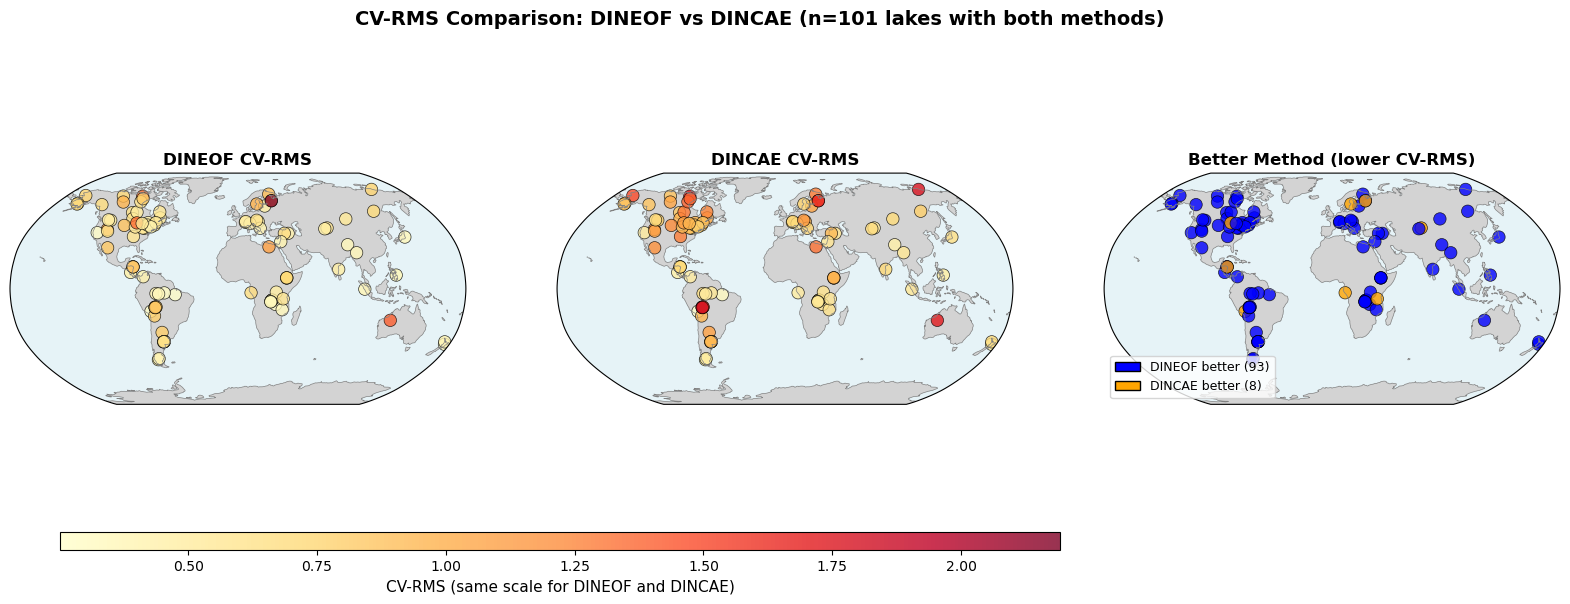


Saved comparison map: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/archive/anomaly-20251126-c84211-exp1/dineof_metrics_global_comparison.png


In [15]:
# Create side-by-side comparison map with same color scale
try:
    import matplotlib.pyplot as plt
    import numpy as np
    
    if df_merged is not None and df_merged['lat'].notna().any():
        # Get lakes with BOTH methods for fair comparison
        df_both_loc = df_merged[
            (df_merged['lat'].notna()) & 
            (df_merged['dineof_cvrms'].notna()) & 
            (df_merged['dincae_cvrms'].notna())
        ].copy()
        
        if len(df_both_loc) > 0:
            print(f"Lakes with both DINEOF and DINCAE + location: {len(df_both_loc)}")
            
            # Use same color scale for both plots
            vmin = min(df_both_loc['dineof_cvrms'].min(), df_both_loc['dincae_cvrms'].min())
            vmax = max(df_both_loc['dineof_cvrms'].max(), df_both_loc['dincae_cvrms'].max())
            
            # Calculate which method is better for each lake
            df_both_loc['better_method'] = np.where(
                df_both_loc['dineof_cvrms'] < df_both_loc['dincae_cvrms'],
                'DINEOF', 'DINCAE'
            )
            
            try:
                import cartopy.crs as ccrs
                import cartopy.feature as cfeature
                HAS_CARTOPY = True
            except ImportError:
                HAS_CARTOPY = False
            
            # Create figure with 3 subplots: DINEOF, DINCAE, and Winner
            if HAS_CARTOPY:
                fig, axes = plt.subplots(1, 3, figsize=(20, 6),
                                         subplot_kw={'projection': ccrs.Robinson()})
                
                for ax in axes:
                    ax.set_global()
                    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='none')
                    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)
                    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='gray')
                
                # DINEOF
                sizes1 = scale_sizes(df_dineof['dineof_cvrms'])                
                sc1 = axes[0].scatter(df_both_loc['lon'], df_both_loc['lat'],
                                      c=df_both_loc['dineof_cvrms'], s=80,
                                      cmap='YlOrRd', vmin=vmin, vmax=vmax,
                                      alpha=0.8, edgecolors='black', linewidth=0.5,
                                      transform=ccrs.PlateCarree())
                axes[0].set_title('DINEOF CV-RMS', fontsize=12, fontweight='bold')
                
                # DINCAE
                sizes2 = scale_sizes(df_dineof['dincae_cvrms'])                               
                sc2 = axes[1].scatter(df_both_loc['lon'], df_both_loc['lat'],
                                      c=df_both_loc['dincae_cvrms'], s=80,
                                      cmap='YlOrRd', vmin=vmin, vmax=vmax,
                                      alpha=0.8, edgecolors='black', linewidth=0.5,
                                      transform=ccrs.PlateCarree())
                axes[1].set_title('DINCAE CV-RMS', fontsize=12, fontweight='bold')
                
                # Winner map
                colors = df_both_loc['better_method'].map({'DINEOF': 'blue', 'DINCAE': 'orange'})
                axes[2].scatter(df_both_loc['lon'], df_both_loc['lat'],
                                c=colors, s=80, alpha=0.8, edgecolors='black', linewidth=0.5,
                                transform=ccrs.PlateCarree())
                # Add legend
                from matplotlib.patches import Patch
                n_dineof_wins = (df_both_loc['better_method'] == 'DINEOF').sum()
                n_dincae_wins = (df_both_loc['better_method'] == 'DINCAE').sum()
                legend_elements = [
                    Patch(facecolor='blue', edgecolor='black', label=f'DINEOF better ({n_dineof_wins})'),
                    Patch(facecolor='orange', edgecolor='black', label=f'DINCAE better ({n_dincae_wins})')
                ]
                axes[2].legend(handles=legend_elements, loc='lower left', fontsize=9)
                axes[2].set_title('Better Method (lower CV-RMS)', fontsize=12, fontweight='bold')
                
            else:
                fig, axes = plt.subplots(1, 3, figsize=(20, 6))
                
                # DINEOF
                sc1 = axes[0].scatter(df_both_loc['lon'], df_both_loc['lat'],
                                      c=df_both_loc['dineof_cvrms'], s=80,
                                      cmap='YlOrRd', vmin=vmin, vmax=vmax,
                                      alpha=0.8, edgecolors='black', linewidth=0.5)
                axes[0].set_title('DINEOF CV-RMS', fontsize=12, fontweight='bold')
                axes[0].set_xlim(-180, 180)
                axes[0].set_ylim(-90, 90)
                axes[0].grid(True, alpha=0.3)
                
                # DINCAE
                sc2 = axes[1].scatter(df_both_loc['lon'], df_both_loc['lat'],
                                      c=df_both_loc['dincae_cvrms'], s=80,
                                      cmap='YlOrRd', vmin=vmin, vmax=vmax,
                                      alpha=0.8, edgecolors='black', linewidth=0.5)
                axes[1].set_title('DINCAE CV-RMS', fontsize=12, fontweight='bold')
                axes[1].set_xlim(-180, 180)
                axes[1].set_ylim(-90, 90)
                axes[1].grid(True, alpha=0.3)
                
                # Winner map
                colors = df_both_loc['better_method'].map({'DINEOF': 'blue', 'DINCAE': 'orange'})
                axes[2].scatter(df_both_loc['lon'], df_both_loc['lat'],
                                c=colors, s=80, alpha=0.8, edgecolors='black', linewidth=0.5)
                n_dineof_wins = (df_both_loc['better_method'] == 'DINEOF').sum()
                n_dincae_wins = (df_both_loc['better_method'] == 'DINCAE').sum()
                from matplotlib.patches import Patch
                legend_elements = [
                    Patch(facecolor='blue', edgecolor='black', label=f'DINEOF better ({n_dineof_wins})'),
                    Patch(facecolor='orange', edgecolor='black', label=f'DINCAE better ({n_dincae_wins})')
                ]
                axes[2].legend(handles=legend_elements, loc='lower left', fontsize=9)
                axes[2].set_title('Better Method (lower CV-RMS)', fontsize=12, fontweight='bold')
                axes[2].set_xlim(-180, 180)
                axes[2].set_ylim(-90, 90)
                axes[2].grid(True, alpha=0.3)
            
            # Add shared colorbar
            fig.subplots_adjust(bottom=0.15)
            cbar_ax = fig.add_axes([0.15, 0.08, 0.5, 0.03])
            cbar = fig.colorbar(sc1, cax=cbar_ax, orientation='horizontal')
            cbar.set_label('CV-RMS (same scale for DINEOF and DINCAE)', fontsize=11)
            
            plt.suptitle(f'CV-RMS Comparison: DINEOF vs DINCAE (n={len(df_both_loc)} lakes with both methods)',
                         fontsize=14, fontweight='bold', y=0.98)
            
            # Save figure
            fig_path = out_path / "dineof_metrics_global_comparison.png"
            plt.savefig(fig_path, dpi=150, bbox_inches='tight')
            plt.show()
            print(f"\nSaved comparison map: {fig_path}")
        else:
            print("No lakes with both DINEOF and DINCAE data + location for comparison map")
            
except ImportError as e:
    print(f"Error creating comparison map: {e}")

## Comparison Analysis: Which Method Performs Better?

In [16]:
if len(df) > 0:
    both_mask = df['dineof_cvrms'].notna() & df['dincae_cvrms'].notna()
    df_both = df[both_mask].copy()
    
    if len(df_both) > 0:
        df_both['cvrms_diff'] = df_both['dincae_cvrms'] - df_both['dineof_cvrms']
        df_both['dineof_better'] = df_both['dineof_cvrms'] < df_both['dincae_cvrms']
        df_both['dincae_better'] = df_both['dincae_cvrms'] < df_both['dineof_cvrms']
        
        n_dineof_better = df_both['dineof_better'].sum()
        n_dincae_better = df_both['dincae_better'].sum()
        n_equal = len(df_both) - n_dineof_better - n_dincae_better
        
        print(f"Lakes with both DINEOF and DINCAE: {len(df_both)}")
        print(f"  - DINEOF better (lower CV-RMS): {n_dineof_better} ({100*n_dineof_better/len(df_both):.1f}%)")
        print(f"  - DINCAE better (lower CV-RMS): {n_dincae_better} ({100*n_dincae_better/len(df_both):.1f}%)")
        print(f"  - Equal: {n_equal}")
        print()
        print(f"Mean DINEOF CV-RMS: {df_both['dineof_cvrms'].mean():.4f}")
        print(f"Mean DINCAE CV-RMS: {df_both['dincae_cvrms'].mean():.4f}")
        print(f"Mean difference (DINCAE - DINEOF): {df_both['cvrms_diff'].mean():.4f}")
        
        print("\nLakes where DINCAE significantly outperforms DINEOF (diff < -0.1):")
        dincae_wins = df_both[df_both['cvrms_diff'] < -0.1][['lake_id', 'dineof_cvrms', 'dincae_cvrms', 'cvrms_diff']]
        if len(dincae_wins) > 0:
            display(dincae_wins.head(10))
        else:
            print("  None")
    else:
        print("No lakes with both DINEOF and DINCAE data for comparison")

Lakes with both DINEOF and DINCAE: 103
  - DINEOF better (lower CV-RMS): 95 (92.2%)
  - DINCAE better (lower CV-RMS): 8 (7.8%)
  - Equal: 0

Mean DINEOF CV-RMS: 0.5883
Mean DINCAE CV-RMS: 0.8700
Mean difference (DINCAE - DINEOF): 0.2816

Lakes where DINCAE significantly outperforms DINEOF (diff < -0.1):


,lake_id,dineof_cvrms,dincae_cvrms,cvrms_diff
80,2965,0.6878,0.504395,-0.183405
83,6785,0.9715,0.779640,-0.191860
84,12471,1.3405,1.124591,-0.215909
93,300009807,0.9162,0.719452,-0.196748
101,300012341,2.1919,1.640362,-0.551538


In [17]:
print("\n" + "="*60)
print("DONE!")
print("="*60)
print(f"\nOutput files saved to: {out_path}")
print(f"  - dineof_metrics.csv")
print(f"  - dineof_metrics.json")
print(f"  - dineof_metrics_skipped.txt")
print(f"  - dineof_metrics_plots.png")
print(f"  - dineof_metrics_global_map.png")
print(f"  - dineof_metrics_global_comparison.png")


DONE!

Output files saved to: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/archive/anomaly-20251126-c84211-exp1
  - dineof_metrics.csv
  - dineof_metrics.json
  - dineof_metrics_skipped.txt
  - dineof_metrics_plots.png
  - dineof_metrics_global_map.png
  - dineof_metrics_global_comparison.png
